grants.gov Exploration
======================



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [3]:
#Paths

#Get the top path
top_path = os.path.dirname(os.getcwd())

#Create the path for external data
ext_data = os.path.join(top_path,'data/external')

#Raw path (for html downloads)

raw_data = os.path.join(top_path,'data/raw')

#And external data
proc_data = os.path.join(top_path,'data/processed')

fig_path = os.path.join(top_path,'reports/figures')

#Get date for saving files
today = datetime.utcnow()

today_str = datetime.strftime(today, '%Y_%m_%d')
print("Today's UTC date:", today_str)

Today's UTC date: 2018_05_15


In [4]:
# Add caveats for hidden files and files with multiple dots

def timestamp_string(string, file_ext=True, hidden_file=False):
    """ Adds a timestamp to the end of a string in the format
    YYYY_MM_DD_hhmm.
    
    Parameters:
    string: str
        string to be timestamped
    file_ext: bool
        specifies whether the string has a file extension
    hidden_file: bool
        specifies whether file starts with '.'
    """
    stamp = '_{}'.format(datetime.strftime(datetime.utcnow(), '%Y_%m_%d_%H%M'))
    if file_ext:
        string = string.split('.')
        if hidden_file:
            string[1] = string[1] + stamp
        else:
            string[0] = string[0] + stamp
        return '.'.join(string)
    else:
        return string + stamp

In [5]:
def value_counts_bar(df, col, sort='values', n=20, norm=False, missing=False, **plot_kwargs):
    """ Plots a horizontal bar chart of value counts from a column
    in a DataFrame.
    """
    value_counts = df[col].value_counts()
    
    if missing:
        value_counts['NaN'] = sum(pd.isnull(df[col]))
    
    if norm:
        # express as percentage
        value_counts = (value_counts / sum(value_counts)) * 100
    
    if sort=='values':
        value_counts = value_counts.sort_values(ascending=False)[:n]
    elif sort=='index':
        value_counts = value_counts.sort_index(ascending=False).iloc[:n]
    ax = value_counts.plot(kind='barh', **plot_kwargs)
    ax.invert_yaxis()
    
    if norm:
        ax.set_xlabel('Value Percentage (%)')
        ax.set_ylabel(col)
    return ax

In [6]:
health_grants_df = pd.read_csv('../data/health_research_grants_2018_13_04.csv'
    ).drop('Unnamed: 0', axis=1)

In [7]:
import string

def standardise_column_names(df, remove_punct=True):
    """ Converts all DataFrame column names to lower case replacing
    whitespace of any length with a single underscore. Can also strip
    all punctuation from column names.
    
    Parameters
    ----------
    df: pandas.DataFrame
        DataFrame with non-standardised column names.
    remove_punct: bool (default True)
        If True will remove all punctuation from column names.
    
    Returns
    -------
    df: pandas.DataFrame
        DataFrame with standardised column names.

    Example
    -------
    >>> df = pd.DataFrame({'Column With Spaces': [1,2,3,4,5],
                           'Column-With-Hyphens&Others/': [6,7,8,9,10],
                           'Too    Many Spaces': [11,12,13,14,15],
                           })
    >>> df = standardise_column_names(df)
    >>> print(df.columns)
    Index(['column_with_spaces',
           'column_with_hyphens_others',
           'too_many_spaces'], dtype='object')
    """
    
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

    for c in df.columns:
        c_mod = c.lower()
        if remove_punct:            
            c_mod = c_mod.translate(translator)
        c_mod = '_'.join(c_mod.split(' '))
        if c_mod[-1] == '_':
            c_mod = c_mod[:-1]
        c_mod = re.sub(r'\_+', '_', c_mod)
        df.rename({c: c_mod}, inplace=True, axis=1)
    return df

In [8]:
health_grants_df = standardise_column_names(health_grants_df)

In [9]:
health_grants_df.head(3)

,agency_name,lad13nm,participant_name,project_start_date,project_title,public_description,dataset_id,project_id,paragraph_vectors,year,grants_funding
0,Health Resources and Services Administration,NaN,NaN,"Apr 03, 2013",Ryan White HIV/AIDS Program Part D Grants for ...,This announcement solicits applications for fi...,grants_gov,HRSA-13-264,[-0.35462067 -0.41949466 -0.27364257 -0.659733...,2013.0,NaN
1,Health Resources and Services Administration,NaN,NaN,"Jan 30, 2012",Ryan White HIV/AIDS Program Part D Grants for ...,The purpose of this funding opportunity announ...,grants_gov,HRSA-12-073,[-0.58284324 -0.42862821 -0.52920008 -0.820197...,2012.0,70000000.0
2,Health Resources and Services Administration,NaN,NaN,"Apr 03, 2013",HIV Early Intervention Services (EIS) Program ...,This announcement solicits applications for fi...,grants_gov,HRSA-13-274,[-0.41496313 -0.20259638 -0.47775218 -1.276504...,2013.0,NaN


In [10]:
len(health_grants_df)

38497

## Exploration

### Categorical Variables

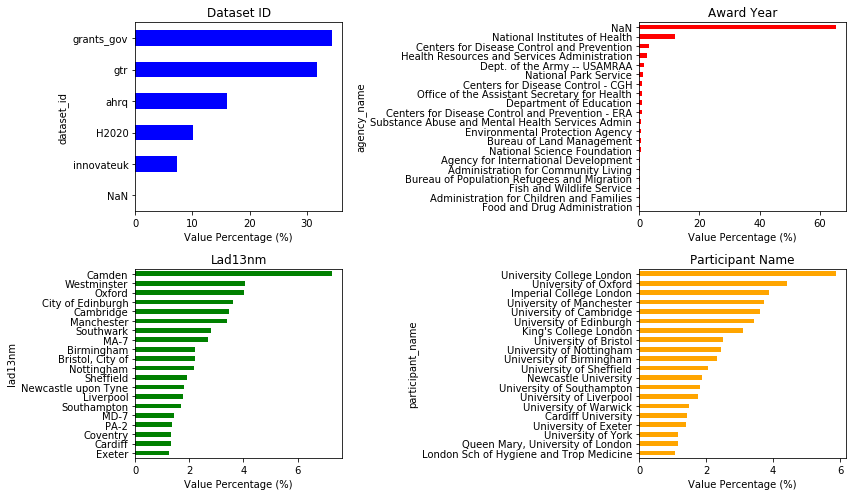

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 7))
value_counts_bar(health_grants_df, 'dataset_id', norm=True, missing=True,
                 **{'ax': axs[0][0], 'color': 'blue', 'title': 'Dataset ID'})
value_counts_bar(health_grants_df, 'agency_name', norm=True, missing=True,
                 **{'ax': axs[0][1], 'color': 'red', 'title': 'Award Year'})
value_counts_bar(health_grants_df, 'lad13nm', norm=True, missing=False,
                 **{'ax': axs[1][0], 'color': 'green', 'title': 'Lad13nm'})
value_counts_bar(health_grants_df, 'participant_name', norm=True, missing=False,
                 **{'ax': axs[1][1], 'color': 'orange', 'title': 'Participant Name'})

plt.tight_layout()

### Dates

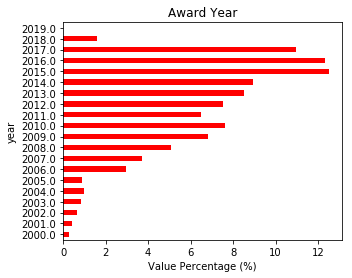

In [12]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax = value_counts_bar(health_grants_df, 'year', norm=True, missing=False, sort='index',
                 **{'ax': ax, 'color': 'red', 'title': 'Award Year'})

In [15]:
def str2date(string):
    
#     string = re.sub(r'\b\d\b', lambda x:  '0' + x.group(0)[0] + x.group(0)[1:], string)
    string = str(string)    
    string = re.sub(' +', ' ', string)
    string = string.strip()

    if len(string.split(',')) == 2:
        dt = datetime.strptime(string, '%b %d, %Y')
    elif len(string.split(':')) == 3:
        dt = datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
    elif len(string.split('-')) == 3:
        dt = datetime.strptime(string, '%Y-%m-%d')
    elif len(string.split('/')) == 3:
        dt = datetime.strptime(string, '%m/%d/%y')
    elif len(string) == 4:
        dt = datetime.strptime(string, '%Y')
    elif string == 'nan':
        dt = pd.NaT

    return dt

In [16]:
start_datetimes = health_grants_df['project_start_date'].apply(lambda x: str2date(x))
health_grants_df['project_start_datetime'] = start_datetimes

In [18]:
health_grants_df[['project_start_date', 'project_start_datetime']]

,project_start_date,project_start_datetime
0,"Apr 03, 2013",2013-04-03
1,"Jan 30, 2012",2012-01-30
2,"Apr 03, 2013",2013-04-03
3,"Mar 18, 2011",2011-03-18
4,"May 24, 2012",2012-05-24
5,"May 02, 2011",2011-05-02
6,"Oct 18, 2012",2012-10-18
7,"Nov 07, 2008",2008-11-07
8,"Mar 21, 2012",2012-03-21
9,"Mar 15, 2013",2013-03-15


In [149]:
health_grants_df.to_csv('../data/{}'.format(timestamp_string('health_research_grants.csv')), index=False)

### Text

### Things to do with text

- Length of texts
- Most/least frequent words
- Bigrams and trigrams
- Phrase grams
- Topic model for themes

Identify new technologies being used in healthcare

Topic modelling to identify the topics within the domain. We don't know what proportion of the datasets are about different methodologies within health - drugs etc.

What population is the document referring to?

## NLP

### Pre-processing Text